<h3>Statement of Purpose</h3>

The purpose of this notebook is to investigate if two patition based clusteing methods ([kmeans and bisecting kmeans](https://en.wikipedia.org/wiki/K-means_clustering)) can be used to extract any meaningful categorization of countries from flow of goods data from the United Nations. The flow of good data can be downloaded or explored [here](http://data.un.org/Explorer.aspx](http://data.un.org/Explorer.aspx). The countries will be clustered based on the difference in exported and imported values aggregated acoss accross broad categories ("rubber and articles thereof"). The objective will be to determine not only if the methods yeild useful results but also if partition based clustering methods are applicable to this problem. 

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib as ml
import scipy as sc
import matplotlib as mp


In [2]:
#imports to set file paths

import os
import sys
#os.environ["PYSPARK_PYTHON"] = "/opt/continuum/anaconda/bin/python"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/usr/local/spark-2.4.5-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/home/harry/spark/spark-3.1.2-bin-hadoop3.2"


In [3]:
#import spark


import pyspark
#import numpy as np
from pyspark.sql import SQLContext
from pyspark import SparkContext

In [4]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[2]").appName("commoditydata").getOrCreate()


In [5]:
#import sql functions


import pyspark.sql.functions as f

<h3>Data Preperation and Cleaning</h3>

We will first load the main data into a dataframe (df), this data is quite large for the memory of the working computer so the spark framework will be employed. The first step will be to filter the data for the correct year, 2016. Subsequently the data will be cleaned of null values and two new datframes made for import and export data on the trade values in USD, these are "dfexp" and "dfimp" respectively. These frames will then be joined to form a new dataframe "dfflow" and a difference column will be added to the dataframe that subtracts the import value from the export value. Finally the columns for country, trade in usd, and category will be taken and pivoted so that and average USD trade value per country per category is established. Here the trade categoies will be columns, the countries the first column and the average values in USD entries.

In [6]:
#read dataframe


df = spark.read.options(header = 'true',  inferSchema='True', delimiter=',').csv('/home/harry/exports/commodity_trade_statistics_data.csv')

In [7]:
df.show()

+---------------+----+---------+--------------------+------+---------+---------+---------------+-----------+---------------+
|country_or_area|year|comm_code|           commodity|  flow|trade_usd|weight_kg|  quantity_name|   quantity|       category|
+---------------+----+---------+--------------------+------+---------+---------+---------------+-----------+---------------+
|    Afghanistan|2016|   010410|         Sheep, live|Export|     6088|     2339|Number of items|       51.0|01_live_animals|
|    Afghanistan|2016|   010420|         Goats, live|Export|     3958|      984|Number of items|       53.0|01_live_animals|
|    Afghanistan|2008|   010210|Bovine animals, l...|Import|  1026804|      272|Number of items|     3769.0|01_live_animals|
|        Albania|2016|   010290|Bovine animals, l...|Import|  2414533|  1114023|Number of items|     6853.0|01_live_animals|
|        Albania|2016|   010392|Swine, live excep...|Import| 14265937|  9484953|Number of items|    96040.0|01_live_animals|


In [8]:

df.printSchema()

root
 |-- country_or_area: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- comm_code: string (nullable = true)
 |-- commodity: string (nullable = true)
 |-- flow: string (nullable = true)
 |-- trade_usd: long (nullable = true)
 |-- weight_kg: long (nullable = true)
 |-- quantity_name: string (nullable = true)
 |-- quantity: double (nullable = true)
 |-- category: string (nullable = true)



In [10]:
df.schema.names

['country_or_area',
 'year',
 'comm_code',
 'commodity',
 'flow',
 'trade_usd',
 'weight_kg',
 'quantity_name',
 'quantity',
 'category']

In [11]:
df.drop(df.comm_code).printSchema()

root
 |-- country_or_area: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- commodity: string (nullable = true)
 |-- flow: string (nullable = true)
 |-- trade_usd: long (nullable = true)
 |-- weight_kg: long (nullable = true)
 |-- quantity_name: string (nullable = true)
 |-- quantity: double (nullable = true)
 |-- category: string (nullable = true)



In [12]:
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---------------+----+---------+---------+----+---------+---------+-------------+--------+--------+
|country_or_area|year|comm_code|commodity|flow|trade_usd|weight_kg|quantity_name|quantity|category|
+---------------+----+---------+---------+----+---------+---------+-------------+--------+--------+
|              0| 726|      726|      726|1452|     1452|   129927|         1452|  306309|    1452|
+---------------+----+---------+---------+----+---------+---------+-------------+--------+--------+



In [13]:
df.filter(df.year == 2016).select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---------------+----+---------+---------+----+---------+---------+-------------+--------+--------+
|country_or_area|year|comm_code|commodity|flow|trade_usd|weight_kg|quantity_name|quantity|category|
+---------------+----+---------+---------+----+---------+---------+-------------+--------+--------+
|              0|   0|        0|        0|  61|       61|     6938|           61|   15206|      61|
+---------------+----+---------+---------+----+---------+---------+-------------+--------+--------+



In [14]:
#df = df.na.drop()

df.filter(df.category == 'all_commodities').select('category').distinct().show()

+---------------+
|       category|
+---------------+
|all_commodities|
+---------------+



In [15]:
#Create the export dataframe.

dfexp = df.filter((df.year == 2016) & (df.flow == 'Export'))

#dfexp = df.filter((df.year == 2016) & (df.flow == 'Export') & (df.weight_kg.isNotNull()) & (df.trade_usd.isNotNull())).drop("comm_code", "year")

dfexpu = df.filter((df.year == 2016) & (df.flow == 'Export') & (df.quantity_name != 'No Quantity') & (df.quantity_name.isNotNull())).drop("comm_code", "year")

dfexp = dfexp.withColumn('cost_per_kg', dfexp['trade_usd']/dfexp['weight_kg'])

dfexpu = dfexp.withColumn('cost_per_kg', dfexp['trade_usd']/dfexp['weight_kg'])

In [16]:
#Create the import dataframe.

dfimp = df.filter((df.year == 2016) & (df.flow == 'Import'))

#dfimp = df.filter((df.year == 2016) & (df.flow == 'Import') & (df.weight_kg.isNotNull()) & (df.trade_usd.isNotNull())).drop("comm_code", "year")

dfimpu = df.filter((df.year == 2016) & (df.flow == 'Import') & (df.quantity_name != 'No Quantity') & (df.quantity_name.isNotNull())).drop("comm_code", "year")

dfimp = dfimp.withColumn('cost_per_kg', dfimp['trade_usd']/dfimp['weight_kg'])

dfimpu = dfimp.withColumn('cost_per_kg', dfimp['trade_usd']/dfimp['weight_kg'])

In [17]:

#Now we perform the join using an outer join function on the import and export dataframes. 



#dfflow = dfexp.select('country_or_area', 'commodity', 'category', f.col('trade_usd').alias('trade_usd_exp'), f.col('weight_kg').alias('weight_kg_exp')).join(dfimp.select('country_or_area', 'commodity', 'category', f.col('trade_usd').alias('trade_usd_imp'), f.col('weight_kg').alias('weight_kg_imp')), ['country_or_area', 'commodity', 'category'], 'outer')


dfflow = dfexp.select('country_or_area', 'commodity', 'category', 'quantity_name', f.col('trade_usd').alias('trade_usd_exp'), f.col('weight_kg').alias('weight_kg_exp'), f.col('quantity').alias('quantity_exp')).join(dfimp.select('country_or_area', 'commodity', 'category', 'quantity_name', f.col('trade_usd').alias('trade_usd_imp'), f.col('weight_kg').alias('weight_kg_imp'), f.col('quantity').alias('quantity_imp')), ['country_or_area', 'commodity', 'category', 'quantity_name'], 'outer')





In [18]:
dfflow.filter(dfflow.category == 'all_commodities').select('category').distinct().show()

+---------------+
|       category|
+---------------+
|all_commodities|
+---------------+



In [19]:
#We will create columns the give a net flow of goods in terms of currency in USD, in kg, and finally in a normalized price per kilogram.


dfflow = dfflow.withColumn("difference_usd", dfflow['trade_usd_imp'] - dfflow['trade_usd_exp']).withColumn("difference_kg", dfflow['weight_kg_imp'] - dfflow['weight_kg_exp']).withColumn("difference_usd_kg", (dfflow['trade_usd_imp'] - dfflow['trade_usd_exp'])/(dfflow['weight_kg_imp'] - dfflow['weight_kg_exp']))


#dfflow = dfflow.withColumn("difference_usd", dfflow['trade_usd_imp'] - dfflow['trade_usd_exp']).withColumn("difference_kg", dfflow['weight_kg_imp'] - dfflow['weight_kg_exp']).withColumn("difference_usd_kg", (dfflow['trade_usd_imp'] - dfflow['trade_usd_exp'])/(dfflow['weight_kg_imp'] - dfflow['weight_kg_exp'])).withColumn("difference_usd", dfflow['trade_usd_imp'] - dfflow['trade_usd_exp']).withColumn("difference_kg", dfflow['weight_kg_imp'] - dfflow['weight_kg_exp']).withColumn("difference_usd_unit", (dfflow['trade_usd_imp'] - dfflow['trade_usd_exp'])/(dfflow['quantity_imp'] - dfflow['quantity_exp']))


In [20]:
#Eliminate white space and special characters from the target columns

dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', ' ', '_'))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', '-', '_'))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', '<', 'lt'))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', '>', 'gt'))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', '"', ''))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', '#', ''))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', ':', ''))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', ',', ''))
dfflow = dfflow.withColumn('commodity', f.regexp_replace('commodity', '\\.', ''))
dfflow = dfflow.withColumn('category', f.regexp_replace('category', ' ', '_'))
#dfflow = dfflow.withColumn('quantity_name', f.regexp_replace('quantity_name', ' ', '_'))

In [21]:
#dfflow.show()

In [22]:
dfflow.printSchema()

root
 |-- country_or_area: string (nullable = true)
 |-- commodity: string (nullable = true)
 |-- category: string (nullable = true)
 |-- quantity_name: string (nullable = true)
 |-- trade_usd_exp: long (nullable = true)
 |-- weight_kg_exp: long (nullable = true)
 |-- quantity_exp: double (nullable = true)
 |-- trade_usd_imp: long (nullable = true)
 |-- weight_kg_imp: long (nullable = true)
 |-- quantity_imp: double (nullable = true)
 |-- difference_usd: long (nullable = true)
 |-- difference_kg: long (nullable = true)
 |-- difference_usd_kg: double (nullable = true)



In [23]:

#df1 = dfusd.groupBy('country_or_area').pivot('commodity').avg('trade_usd')

#df2 = dfkgc.groupBy('country_or_area').pivot('category').avg('cost_per_kg')

#df3 = dfflow.select('country_or_area', 'category', 'difference_usd_kg').groupby('country_or_area').pivot('category').avg('difference_usd_kg')



df3 = dfflow.select('country_or_area', 'category', 'difference_usd').groupby('country_or_area').pivot('category').avg('difference_usd')


In [24]:
df3.printSchema()

root
 |-- country_or_area: string (nullable = true)
 |-- 01_live_animals: double (nullable = true)
 |-- 02_meat_and_edible_meat_offal: double (nullable = true)
 |-- 03_fish_crustaceans_molluscs_aquatic_invertebrates_ne: double (nullable = true)
 |-- 04_dairy_products_eggs_honey_edible_animal_product_nes: double (nullable = true)
 |-- 05_products_of_animal_origin_nes: double (nullable = true)
 |-- 06_live_trees_plants_bulbs_roots_cut_flowers_etc: double (nullable = true)
 |-- 07_edible_vegetables_and_certain_roots_and_tubers: double (nullable = true)
 |-- 08_edible_fruit_nuts_peel_of_citrus_fruit_melons: double (nullable = true)
 |-- 09_coffee_tea_mate_and_spices: double (nullable = true)
 |-- 10_cereals: double (nullable = true)
 |-- 11_milling_products_malt_starches_inulin_wheat_glute: double (nullable = true)
 |-- 12_oil_seed_oleagic_fruits_grain_seed_fruit_etc_ne: double (nullable = true)
 |-- 13_lac_gums_resins_vegetable_saps_and_extracts_nes: double (nullable = true)
 |-- 14_veget

In [25]:
df3.select(f.count(f.when(df3.all_commodities.isNull() == True, df3.all_commodities)), f.count(f.when(df3.all_commodities == 0, df3.all_commodities))).show()

+----------------------------------------------------------------------------+---------------------------------------------------------------+
|count(CASE WHEN ((all_commodities IS NULL) = true) THEN all_commodities END)|count(CASE WHEN (all_commodities = 0) THEN all_commodities END)|
+----------------------------------------------------------------------------+---------------------------------------------------------------+
|                                                                           0|                                                              0|
+----------------------------------------------------------------------------+---------------------------------------------------------------+



In [26]:
#Normalise the values for trade.

for i in df3.columns[1:len(df3.columns)]:
    df3 = df3.withColumn(i, f.col(i)/f.abs('all_commodities'))
    
    


In [27]:
#check that NA values are removed

df3.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df3.columns[1:]]
   ).show()

+---------------+-----------------------------+-----------------------------------------------------+------------------------------------------------------+--------------------------------+------------------------------------------------+-------------------------------------------------+------------------------------------------------+-----------------------------+----------+----------------------------------------------------+--------------------------------------------------+--------------------------------------------------+------------------------------------------------------+------------------------------------------------------+----------------------------------------------+---------------------------------+-------------------------------+-----------------------------------------------------+--------------------------------------------+------------------------------------+--------------------------------+-------------------------------------------------+-------------------------

In [103]:
#We double check all null values are filled.

df3 = df3.drop('all_commodities').drop('99_commodities_not_specified_according_to_kind')
df3 = df3.fillna(value = 0)
df3 = df3.na.fill(value = 0)

<h3>Modeling</h3>

   The data will be modeled using two methods, kmeans and bisecting kmeans. Both are partition based and require a number of clusters and seed to be set. the seed will be set to one since values for the commodity flow have been normalized to the measured values of all imports and exports. An average [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) will be used to evaluate the clustering method. Note that k values of size two in both cases have been ignored for triviality. 

In [104]:
#Make assembled vector suitable for ml in spark

from pyspark.ml.feature import VectorAssembler


vectorAssembler = VectorAssembler(inputCols = df3.columns[1:], outputCol = 'features')


In [105]:
#make transformed dataframe. "features" is the column of interest

cdf = vectorAssembler.transform(df3)

In [106]:
#Do a kmeans clustering. We make a function to save time and space.


from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def kmeansn(data, k, seed):
    
    # Loads data.
    dataset = data
    
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(seed)
    model = kmeans.fit(dataset)
    
    # Make predictions
    predictions = model.transform(dataset)
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    
    # Shows the result.
    centers = model.clusterCenters()
    #print("Cluster Centers: ")
    #for center in centers:
    #print(center)
    
    
    return silhouette, predictions, centers
    
    

In [107]:

mc =  range(2, 10, 1)

sils = []

for i in mc:
    clus = kmeansn(cdf, i, 1)
    sils.append(clus[0])
    


Silhouette with squared euclidean distance = 0.9816397200549676
Silhouette with squared euclidean distance = 0.9789593255889394
Silhouette with squared euclidean distance = 0.9540435911025887
Silhouette with squared euclidean distance = 0.8627261105964246
Silhouette with squared euclidean distance = 0.7749473318102981
Silhouette with squared euclidean distance = 0.845597153414062
Silhouette with squared euclidean distance = 0.8375338401679574
Silhouette with squared euclidean distance = 0.8658413772078873


7


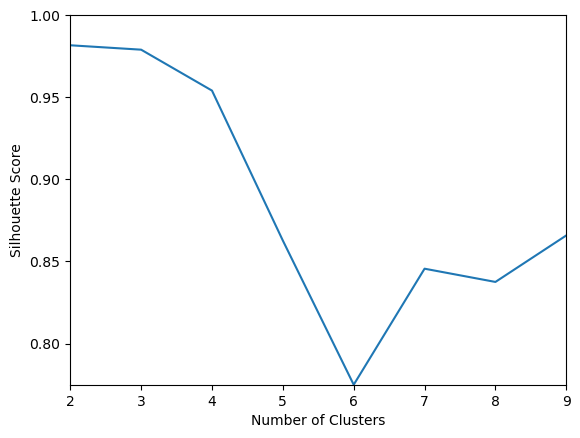

In [108]:
import matplotlib.pyplot as plt
import matplotlib


print(mc[-1] - mc[0])

plt.plot(mc, sils)
plt.axis([min(mc), max(mc), min(sils), 1])
plt.locator_params(axis='x', nbins=mc[-1] - mc[0])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

N.B. silhouette score for a clustering using the data based on the price per unit of individual commodities

In [109]:
bgrp = kmeansn(cdf, mc[sils.index(max(sils[2:]))], 1)
#bgrp = kmeansn(cdf, 2, 1)


Silhouette with squared euclidean distance = 0.9540435911025887


In [110]:
cents = [c for c in bgrp[2]]
cen = np.array(list(zip(cents)))

In [111]:
#print(cen)

In [112]:
#plot results.

import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np



def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap,label='Test')
    plt.show()



<ipython-input-112-9860b7c02347>:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


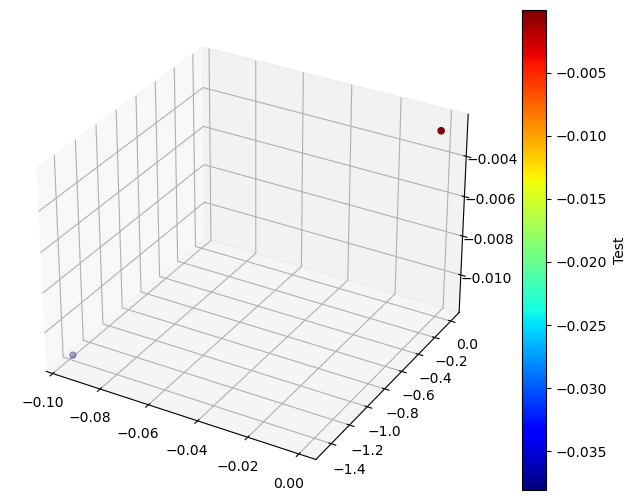

In [113]:
#We make a scatter plot, note that given the high dimensionality of the resulting centers we just use the first few categories.
#Plots using any other dimensions are viable.

scatter3d([cen[0][0][0], cen[1][0][0]], [cen[0][0][1], cen[1][0][1]], [cen[0][0][2], cen[1][0][2]], [cen[0][0][4], cen[1][0][4]])

In [114]:
#Load data on human development index, this may be used to look for correlations wth the cluster labels.

dcs = pd.read_csv('hdindexData.csv')

In [115]:


c1 =  df3.select('country_or_area').collect()
c2 = bgrp[1].select('prediction').collect()
#cz = pd.

In [118]:
cz1 = pd.DataFrame({'country_or_area':[i[0] for i in c1], 'prediction':[l[0] for l in c2]})
cz1.head()

,country_or_area,prediction
0,Rep. of Moldova,0
1,Paraguay,0
2,Senegal,0
3,Cabo Verde,0
4,Sweden,0


In [125]:
dp = cz1[cz1['prediction'] == 1].country_or_area
print(dp)

103    Australia
Name: country_or_area, dtype: object


In [126]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator




def bkmeans(data, k, seed):
    # Loads data.
    dataset = data

    # Trains a bisecting k-means model.
    bkm = BisectingKMeans().setK(k).setSeed(seed)
    model = bkm.fit(dataset)

    # Make predictions
    predictions = model.transform(dataset)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    
    centers = model.clusterCenters()
 
    
    return silhouette, predictions, centers    

In [127]:


mc =  range(2, 10, 1)

sils = []
   
for i in mc:
    clus = bkmeans(cdf, i, 1)
    sils.append(clus[0])


Silhouette with squared euclidean distance = 0.9841331612973854
Silhouette with squared euclidean distance = 0.9092319356000697
Silhouette with squared euclidean distance = 0.907179986191647
Silhouette with squared euclidean distance = 0.9260652198382525
Silhouette with squared euclidean distance = 0.926339750783115
Silhouette with squared euclidean distance = 0.5745504900013416
Silhouette with squared euclidean distance = 0.8279726289918949
Silhouette with squared euclidean distance = 0.6635027025421892


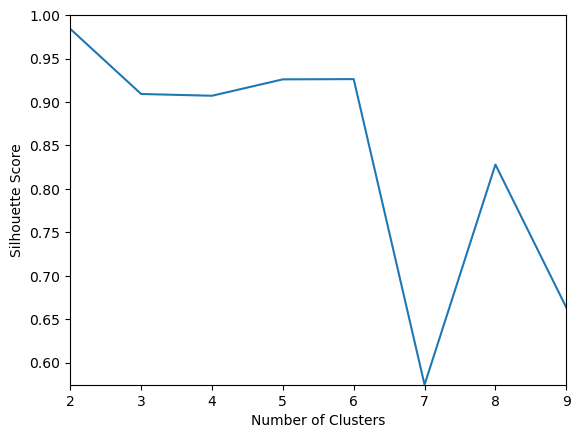

In [128]:
plt.plot(mc, sils)
plt.axis([min(mc), max(mc), min(sils), 1])
plt.locator_params(axis='x', nbins=mc[-1] - mc[0])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [129]:
bbgrp = bkmeans(cdf, mc[sils.index(max(sils[2:]))], 1)

Silhouette with squared euclidean distance = 0.926339750783115


In [130]:
cens = [c for c in bbgrp[2]]
#cen = np.array(list(zip(cents[0],cents[1])))
cen = np.array(list(cens))

In [131]:
print(len(cens), cens[0][0], [cens[i][1] for i in range(0,len(cens))])

6 -0.09584564478665179 [-1.4591850689492116, 0.0, 0.010535543152239956, 0.001798243637537139, -0.000154096542745832, 0.0]


<ipython-input-112-9860b7c02347>:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


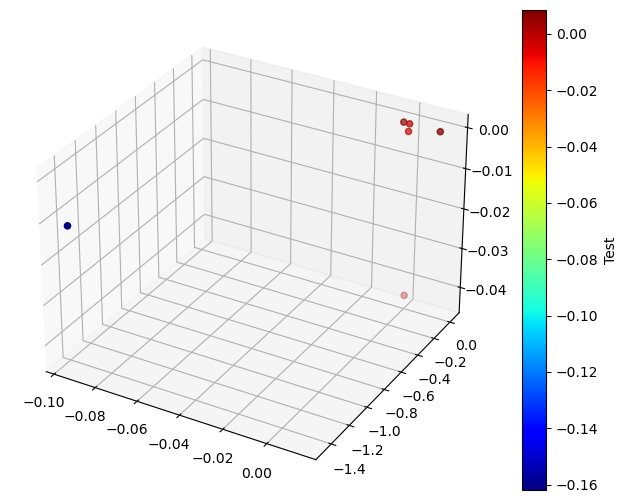

In [132]:
scatter3d([cens[i][0] for i in range(0,len(cens))], [cens[i][1] for i in range(0,len(cens))], [cens[i][2] for i in range(0,len(cens))], [cens[i][3] for i in range(0,len(cens))])

In [133]:
c1 =  df3.select('country_or_area').collect()
c2 = bbgrp[1].select('prediction').collect()

In [143]:
cz2 = pd.DataFrame({'country_or_area':[i[0] for i in c1], 'prediction':[l[0] for l in c2]})
cz2.head()

,country_or_area,prediction
0,Rep. of Moldova,4
1,Paraguay,4
2,Senegal,4
3,Cabo Verde,4
4,Sweden,4


In [161]:
dp2 = cz2[cz2['prediction'] == 0].country_or_area
print(dp2)

103    Australia
Name: country_or_area, dtype: object


In [159]:
g4_df = df3.filter((df3['country_or_area'] == 'Chile') | (df3['country_or_area'] == 'Greenland')).toPandas()


In [160]:
g4_df.head()
#df3.rdd.map(lambda x : sum(x[1:98])).collect()

,country_or_area,01_live_animals,02_meat_and_edible_meat_offal,03_fish_crustaceans_molluscs_aquatic_invertebrates_ne,04_dairy_products_eggs_honey_edible_animal_product_nes,05_products_of_animal_origin_nes,06_live_trees_plants_bulbs_roots_cut_flowers_etc,07_edible_vegetables_and_certain_roots_and_tubers,08_edible_fruit_nuts_peel_of_citrus_fruit_melons,09_coffee_tea_mate_and_spices,...,88_aircraft_spacecraft_and_parts_thereof,89_ships_boats_and_other_floating_structures,90_optical_photo_technical_medical_etc_apparatus,91_clocks_and_watches_and_parts_thereof,92_musical_instruments_parts_and_accessories,93_arms_and_ammunition_parts_and_accessories_thereof,94_furniture_lighting_signs_prefabricated_buildings,95_toys_games_sports_requisites,96_miscellaneous_manufactured_articles,97_works_of_art_collectors_pieces_and_antiques
0,Chile,-0.000569,0.014993,-0.086826,0.003223,-0.000411,-0.003915,-0.00104,-0.134961,0.005605,...,0.007867,0.025928,0.0,0.001073,0.000699,0.000003,0.01794,0.014722,0.003031,0.000721
1,Greenland,0.000000,0.006078,0.000000,0.000000,0.000013,0.001062,0.00000,0.000000,0.000000,...,0.066658,-0.050580,0.0,0.000489,0.000197,0.006973,0.02616,0.004155,0.000000,-0.001531


<h3>Results</h3>

Both the kmeans and bisecting kmeans clustering yeilded suprising results with singular countries placed in outlying groups while the rest were clustered together. In both cases Surinam was assigned it's own group. This result is unusual for the reason that these methods typically do not have [overlapping result](https://spark.apache.org/docs/latest/ml-clustering.html). The average silhouette score also did not develop a clear drop off in either case which leads to the assumption that the k-means clustering employed may miss some nuance. The next step will, therefore, be to apply density and grid based clustering methods to the same data and see if new and more consistent trends might develop.